In [49]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load Data

In [50]:
def load_data(dir):
    data = []
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            print(os.path.join(dir, file))
            df = pd.read_csv(os.path.join(dir, file),on_bad_lines='skip')
            if not df.empty:
                data.append(df)
    return data


try:
    Group1 = load_data("/mnt/ArtHeart/Data/Group 1")
    Group2 = load_data("/mnt/ArtHeart/Data/Group 2")
    Group3 = load_data("/mnt/ArtHeart/Data/Group 3")
except:
    Group1 = load_data("Data/Group 1")
    Group2 = load_data("Data/Group 2")
    Group3 = load_data("Data/Group 3")




Data/Group 1/WRT_WRT_DB:BA:5D:28:F4:C1_2022-08-28 21:43:06.csv
Data/Group 1/WRT_WRT_E1:B8:F8:F2:CE:22_2022-08-28 22:01:02.csv
Data/Group 1/WRT_WRT_D7:DD:AE:B4:E6:35_2022-08-28 21:46:47.csv
Data/Group 1/WRT_WRT_C7:D4:23:10:CC:64_2022-08-28 21:30:36.csv
Data/Group 1/WRT_WRT_EC:BC:BD:73:20:A9_2022-08-28 21:44:43.csv
Data/Group 1/WRT_WRT_F8:8B:C5:5C:D9:5D_2022-08-28 22:32:46.csv
Data/Group 1/WRT_WRT_C7:C3:E6:76:32:D9_2022-08-28 22:27:10.csv
Data/Group 1/WRT_WRT_C8:46:62:32:B0:4F_2022-08-28 22:34:46.csv
Data/Group 1/WRT_WRT_EA:5D:8A:61:72:EE_2022-08-28 22:03:11.csv
Data/Group 1/WRT_WRT_DB:92:4D:E9:1A:1E_2022-08-28 21:50:19.csv
Data/Group 1/WRT_WRT_EE:FA:70:F9:EC:CC_2022-08-28 22:18:49.csv
Data/Group 1/WRT_WRT_E2:D0:DF:09:B7:C4_2022-08-28 21:57:41.csv
Data/Group 1/WRT_WRT_F5:0D:30:BD:11:6F_2022-08-28 22:17:18.csv
Data/Group 1/WRT_WRT_F1:20:19:D6:DA:85_2022-08-28 22:06:27.csv
Data/Group 1/WRT_WRT_EE:59:B1:F9:6A:0F_2022-08-28 21:34:57.csv
Data/Group 1/WRT_WRT_F8:D6:AB:BD:20:53_2022-08-28 21:48

Starting with withing group comparisons

In [51]:
def interpolate_nan(data):
    for i in range(len(data)):
        df = data[i]
        df['UTC'] = df['UTC'].interpolate()
        data[i] = df
    return data


def cut_to_common_length(data):

    # Interpolate NaN values
    data = interpolate_nan(data)

    # Find the shortest dataframe
    shortest_df = min(data, key=lambda x: len(x))

    # Find the first value of UTC in the shortest dataframe that isn't NaN
    first_utc = shortest_df['UTC'].first_valid_index()
    first_utc_value = shortest_df['UTC'][first_utc]

    # Find the length of the dataframe from that point to the end
    length = len(shortest_df.loc[first_utc:])

    # Cut all dataframes to the same length and reset the index
    for i in range(len(data)):
        df = data[i]

        if first_utc_value in df['UTC'].values:
            match_utc_index = df[df['UTC'] == first_utc_value].index[0]
        else:
            match_utc_index = df.iloc[(df['UTC']-first_utc_value).abs().argsort()[:1]].index[0]

        df = df.loc[match_utc_index:].iloc[:length].reset_index(drop=True)
        data[i] = df
    return data




Group1 = cut_to_common_length(Group1)
Group2 = cut_to_common_length(Group2)
Group3 = cut_to_common_length(Group3)
    

    


In [52]:
print(len(Group1))
print(len(Group2))
print(len(Group3))

print(Group1[0].shape)
print(Group1[1].shape)

37
39
32
(143904, 6)
(143904, 6)


In [53]:
from datetime import datetime
import math

def utc_to_datetime_string(utc_value):
    dt = datetime.fromtimestamp(utc_value)
    return dt.strftime('%H %M %S.%f')

def convert_to_datetime(df):
    for i in range(len(df['UTC'])):
        val = df['UTC'][i]
        if not math.isnan(val):
            df['UTC'][i] = utc_to_datetime_string(df['UTC'][i])
    return df




Group1 = [convert_to_datetime(df) for df in Group1]
Group2 = [convert_to_datetime(df) for df in Group2]
Group3 = [convert_to_datetime(df) for df in Group3]



/var/folders/46/g0_bbhvd1tx0ynfjdmv4lf600000gn/T/ipykernel_12099/2079067084.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UTC'][i] = utc_to_datetime_string(df['UTC'][i])


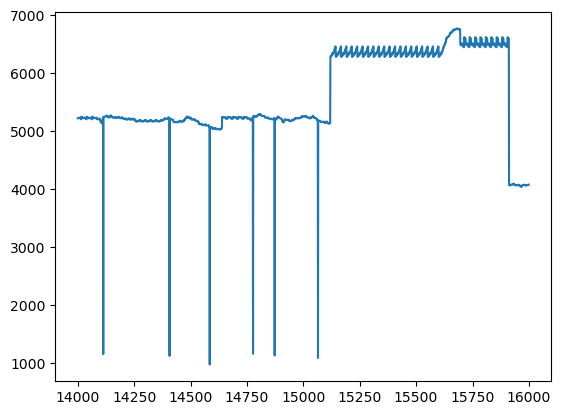

In [54]:

df = Group1[0]


plt.plot(df['DATA'][14000:16000])
plt.show()


sampling rate is: 23.110 Hz


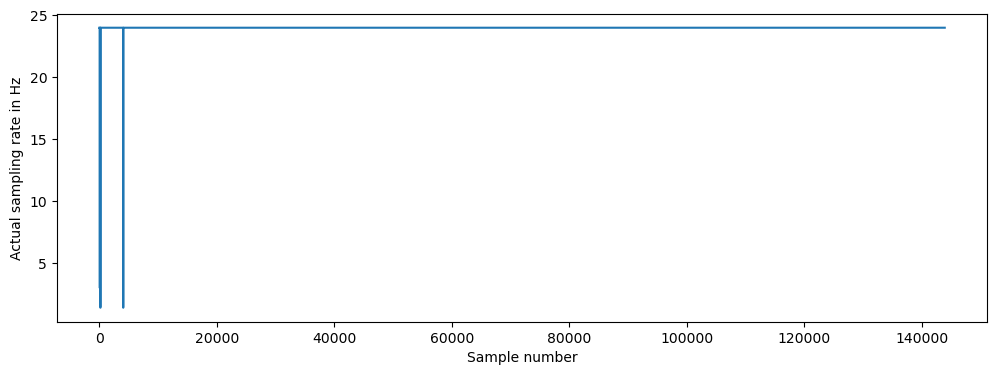

mean sampling rate: 23.989
median sampling rate: 24.000
standard deviation: 0.494


In [48]:
import heartpy as hp
timer = Group1[0]['UTC']
sample_rate = hp.get_samplerate_datetime(timer, timeformat='%H %M %S.%f')
print('sampling rate is: %.3f Hz' %sample_rate)


newtimer = [datetime.strptime(x, '%H %M %S.%f') for x in timer]


elapsed = []
for i in range(len(newtimer) - 1):
    elapsed.append(1 / ((newtimer[i+1] - newtimer[i]).microseconds / 1000000))


plt.figure(figsize=(12,4))
plt.plot(elapsed)
plt.xlabel('Sample number')
plt.ylabel('Actual sampling rate in Hz')
plt.show()

print('mean sampling rate: %.3f' %np.mean(elapsed))
print('median sampling rate: %.3f'%np.median(elapsed))
print('standard deviation: %.3f'%np.std(elapsed))

In [55]:
import heartpy as hp
from scipy.signal import resample


sample_rate = sample_rate * 10

def preprocess_data(data):

    data_clean = []

    for i in range(len(data)):
        df = data[i]



        #df['DATA'] = hp.remove_baseline_wander(df['DATA'], sample_rate=25)
        #df['DATA'] = hp.filtering.smooth_signal(df['DATA'], sample_rate=25, window_length=5, polyorder=3)
        df['DATA'] = hp.filtering.filter_signal(df['DATA'], cutoff=[0.7, 3.5], sample_rate=sample_rate, order=3, filtertype='bandpass')
        #df['DATA'] = hp.scale_data(df['DATA'])
        data_clean.append(resample(df['DATA'], len(df['DATA']) * 10))
        

    return data_clean

Group1 = preprocess_data(Group1)
Group2 = preprocess_data(Group2)
Group3 = preprocess_data(Group3)


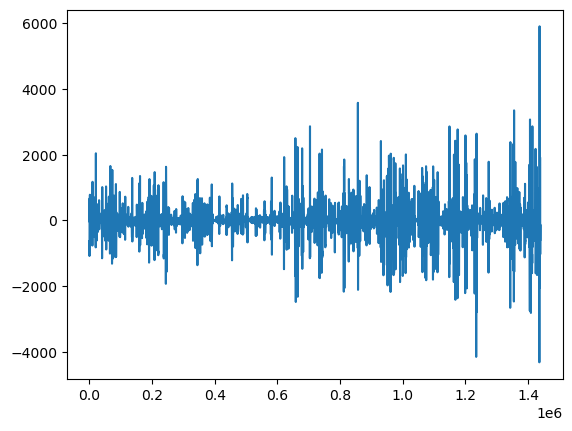

In [57]:
df = Group1[0]


plt.plot(df)
plt.show()

In [59]:
def segment_data(data, windowsize=100):



    for j in range(len(data)):
        raw = data[j]
        mx = np.max(raw)
        mn = np.min(raw)
        global_range = mx - mn


        filtered = []
        for i in range(len(raw) // windowsize):
            start = i * windowsize
            end = (i + 1) * windowsize
            sliced = raw[start:end]
            rng = np.max(sliced) - np.min(sliced)

            if ((rng >= (0.5 * global_range))
                or
                (np.max(sliced) >= 0.9 * mx)
                or
                (np.min(sliced) <= mn + (0.1 * mn))):

                for x in sliced:
                    filtered.append(0)
            else:
                for x in sliced:
                    filtered.append(x)

        for k in range(len(filtered)):
            wd, m = hp.process(filtered[k], sample_rate = sample_rate,
                       high_precision=True, clean_rr=True)


Group1 = segment_data(Group1)

TypeError: object of type 'NoneType' has no len()